# Part 1: Reconstruction of a positive wavefunction

## Getting Started

The following imports are needed to run this tutorial:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from qucumber.binary_rbm import BinaryRBM
from qucumber.quantum_reconstruction import QuantumReconstruction
from qucumber.positive_wavefunction import PositiveWavefunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.data as data
import qucumber.utils.training_statistics as ts

import quantum_ising_chain as TFIM # for calculating observables after training. More later...

The _BinaryRBM_ class in *binary_rbm.py* contains the generic properties of an RBM with a binary visible and hidden layer (e.g. it's effective energy and sampling the hidden and visible layers). 

The actual quantum wavefunction reconstruction occurs in the _QuantumReconstruction_ class in *quantum_reconstruction.py*. A _QuantumReconstruction_ object is initialized with a neural network state (in this case, a PositiveWavefunction object).

*callbacks.py* contains functions that allow the user to evaluate the quality of the training (i.e. based on the fidelity or KL divergence).

## Training

Let's beging with training the RBM on a positive wavefunction. We consider the quantum Ising model with Hamiltonian $H=-J\sum_{\langle i j \rangle} S^z_i S^z_j - h \sum_i S^x_i$
at its quantum critical point $h/J=1$.  The training data has been generated and is contained in the file *tfim1d_N10_train_samples.txt*.  It contains 10,000 measurements of the $S^z$ states of 10 qubits, represented as zeros or ones.

To evaluate how well the RBM is training, we compute the fidelity, $|\langle \psi|\psi_{\rm RBM} \rangle|^2$, between the true wavefunction of the system and the wavefunction the RBM reconstructs. First, we need to load our training data and the true wavefunction of this system.

In [2]:
train_samples_path = 'tfim1d_train_samples.txt'
psi_path           = 'tfim1d_psi.txt'

train_samples,target_psi = data.load_data(train_samples_path,psi_path)

The following arguments are required to construct a **PositiveWavefunction** neural network state:

1. **The number of visible units**. This is 10 for the case of our dataset.
2. **The number of hidden units in the hidden layer of the RBM**. This number is set to the number of visible units by default (10 in the case of our dataset).

In [3]:
nv = train_samples.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv,num_hidden=nh)

Now we can specify the parameters of the training process:

1. **epochs**: the number of epochs, i.e. training cycles that will be performed; 1000 should be fine
2. **batch_size**: the number of data points used in the positive phase of the gradient; we'll go with 100
3. **num_chains**: the number of data points used in the negative phase of the gradient. Keeping this larger than the *batch_size* is preferred; we'll go with 200
4. **CD**: the number of contrastive divergence steps; CD=1 seems to be good enough in most cases
5. **lr**: the learning rate; we will use a learning rate of 0.01 here
6. **log_every**: how often you would like the program to update you during the training; we choose 50 - that is, every 50 epochs the program will print out the fidelity. This parameter is required in the *MetricEvaluator*.

In [4]:
epochs     = 1000
batch_size = 100
num_chains = 200
CD         = 1
lr         = 0.01
log_every  = 50

Once we initialize the parameters of the *PositiveWavefunction* and the *MetricEvaluator*, we can now begin training. Our *QuantumReconstruction* object, *qr* (see below), contains a function called *fit* that executes the training process.

In [5]:
nn_state.space = nn_state.generate_Hilbert_space(nv) # generate the entire visible space of the system.
callbacks = [MetricEvaluator(log_every,{'Fidelity':ts.fidelity,'KL':ts.KL},target_psi=target_psi)]

qr = QuantumReconstruction(nn_state)

In [6]:
nn_state.initialize_parameters() # randomize the network parameters.
qr.fit(train_samples, epochs, batch_size, num_chains, CD,lr, progbar=False,callbacks=callbacks)

Epoch = 50	Fidelity = 0.785383	KL = 0.441264	
Epoch = 100	Fidelity = 0.894514	KL = 0.208556	
Epoch = 150	Fidelity = 0.935645	KL = 0.125355	
Epoch = 200	Fidelity = 0.958977	KL = 0.080373	
Epoch = 250	Fidelity = 0.970116	KL = 0.058963	
Epoch = 300	Fidelity = 0.977806	KL = 0.043968	
Epoch = 350	Fidelity = 0.979086	KL = 0.041768	
Epoch = 400	Fidelity = 0.981559	KL = 0.037034	
Epoch = 450	Fidelity = 0.985201	KL = 0.029750	
Epoch = 500	Fidelity = 0.987439	KL = 0.025278	
Epoch = 550	Fidelity = 0.988868	KL = 0.022384	
Epoch = 600	Fidelity = 0.991312	KL = 0.017393	
Epoch = 650	Fidelity = 0.991913	KL = 0.016160	
Epoch = 700	Fidelity = 0.992833	KL = 0.014334	
Epoch = 750	Fidelity = 0.992946	KL = 0.014146	
Epoch = 800	Fidelity = 0.993429	KL = 0.013104	
Epoch = 850	Fidelity = 0.993416	KL = 0.013208	
Epoch = 900	Fidelity = 0.994565	KL = 0.010874	
Epoch = 950	Fidelity = 0.994806	KL = 0.010380	
Epoch = 1000	Fidelity = 0.995174	KL = 0.009641	

Elapsed time = 125.45


## After Training 

After training the RBM, the *fit* function will have stored the trained weights and biases. Now, we can generate samples from the trained RBM and calculate physical observables.

We have created an example python file called *quantum_ising_chain.py* that calculates the energy and magnetization of a TFIM.

*quantum_ising_chain* (imported as *TFIM*) comprises of a class called *TransverseFieldIsingChain*. A *TransverseFieldIsingChain* is instantiated with the following arguments:

1. **hx**: This is the *h* value of the TFIM (1 in the case of our dataset).
2. **n_measurements**: The number of samples to be generated from the trained RBM. These samples will be used to calculate the observables.

In [7]:
n_measurements = 5000
hx             = 1

tfim           = TFIM.TransverseFieldIsingChain(hx,n_measurements)

To go ahead and calculate the energy and magnetization of the 50,000 generated samples, the *tfim* object has a function called *run* which will output a dictionary containing the energy (key: 'energy') and the magnetization (key: 'sigmaZ'). 

Text(0,0.5,'Magnetization')

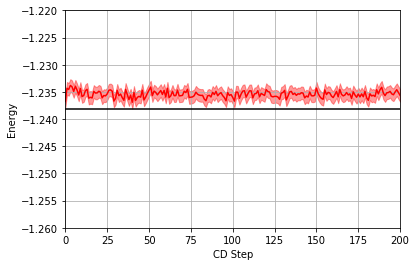

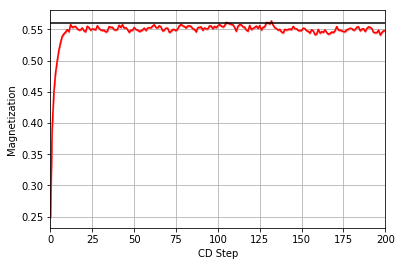

In [8]:
n_eq = 200
simulation = tfim.Run(nn_state,n_eq, show_convergence=True)

step = list(range(n_eq+1))

Energy     = simulation['energy']['energies']
err_energy = simulation['energy']['error']

sigmaZ = simulation['sigmaZ']['sZ']
err_sZ = simulation['energy']['error']

plt.figure(1)
ax1 = plt.axes()
ax1.plot(step, Energy, color='red')
ax1.axhline(-1.2381, color='black')
ax1.fill_between(step, Energy-err_energy, Energy+err_energy, color='red', alpha=0.4) 
ax1.grid()
ax1.set_xlim(0,n_eq)
ax1.set_ylim(-1.26,-1.22)
ax1.set_xlabel('CD Step')
ax1.set_ylabel('Energy')

plt.figure(2)
ax2 = plt.axes()
ax2.plot(step, sigmaZ, color='red')
ax2.axhline(0.5610, color='black')
ax2.fill_between(step, sigmaZ-err_sZ, sigmaZ+err_sZ, color='red', alpha=0.4) 
ax2.grid()
ax2.set_xlim(0,n_eq)
ax2.set_xlabel('CD Step')
ax2.set_ylabel('Magnetization')

You can see a brief transient period in each observable, before the state of the machine "warms up" to equilibrium.  After that, the values fluctuate around the mean.  The exact value for the energy is -1.2381, and for the magnetization is 0.5610.